# MICROPROBING - very similar to other example notebook - but forcing the size..

Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")

You also need: 

* emcee               https://emcee.readthedocs.io/en/stable/user/install/

* prfpy               https://github.com/VU-Cog-Sci/prfpy.git (or https://github.com/spinoza-centre/prfpy_csenf.git if you want the contrast sensitivity function.)

* dag_prf_utils       https://github.com/mdaghlian/dag_prf_utils.git


Also a bit of an apology... There is some inconsistency in naming between prfpy and dag_prf_utils. I promise there is a good reason for this. I want prfpy to be backwards compatible. But, some names interfere with each other, when you start including other models (e.g., size, compared to size_1, and size_2 in the DN model). Here is the mapping for the gaussian model:

```
prfpy       dag_prf_utils

mu_x        x
mu_y        y
size        size_1
beta        amp_1
baseline    bold_baseline
hrf_1       hrf_deriv
hrf_2       hrf_disp


```

Most of the time you shouldn't have to think about it...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


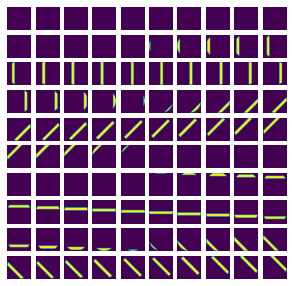

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0])

# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
# Load the runs

psc_runs = np.load('eg_data.npy')

# Testing MCMC

In [12]:
from prfpy_bayes.micro_probe import MicroProb
# Start by making the bprf objects
bprf = MicroProb(
    prfpy_model=prfpy_model,
    real_ts=psc_runs,
    )
bprf.run_mcmc_fit(
    initial_guess=[0,0],
    idx=0, 
    n_walkers=10,
    n_steps=100, 
    eps=10, 

)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:55: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:55: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:55: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages

prf_params.shape[-1]=8
include hrf = True
include rsq = True


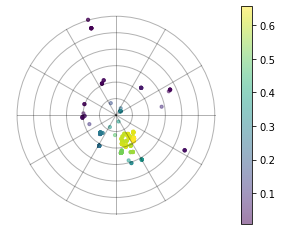

In [14]:
bprf.sampler[0].visual_field(
    th={},
    dot_col='rsq'    ,
    dot_size=10,
)

# MCMC implementation - sticking "emcee" on top of prfpy
Here i show how to stick mcmc on top of prfpy to do some fitting

Essentially following: https://emcee.readthedocs.io/en/stable/tutorials/line/

But applied to prfpy 

In [13]:
# Parameters to fit and their bounds
# Bounds
p2fit = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'amp_1' : [-100, 100], # Allow for negative values
}
size_1_fixed = 0.01 # TINY PRFS!!!!

# index of the parameters to fit
p2fit_id = {
    0 : 'x',
    1 : 'y',
    2 : 'amp_1',
}

# Now we need to define the log "prior"
# Here, we assume that the prior is uniform, i.e., all values are equally likely
# But anything that is not within the bounds is not allowed
def ln_prior(params):
    p_out = 0
    for i in range(len(params)):
        param_index = p2fit_id[i] # Get the parameter name
        # Check if the parameter is within the bounds
        if (params[i] < p2fit[param_index][0]) or (params[i] > p2fit[param_index][1]):            
            p_out += -np.inf # If outside the bounds add -inf
        else:
            p_out += 0
    return p_out

# Now we need to define the log likelihood
# I'm doing this based on the difference between the predicted and observed time series
# First create the prfpy model
gg = Iso2DGaussianModel(
    stimulus=prf_stim,                                  # The stimulus we made earlier
    hrf=[1,4.6,0],                                        # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
    )

def ln_likelihood(params, response):
    # Get the predicted time series
    pred = gg.return_prediction(
        mu_x=np.array([params[0]]),
        mu_y=np.array([params[1]]),
        size=np.array([size_1_fixed]), # Fixed size
        beta=np.array([params[2]]),
        baseline=np.array([0]),
    )
    # Calculate the difference between the predicted and observed time series
    diff = response - pred
    # Calculate the log likelihood
    return -0.5 * np.sum(diff**2)

# Now we need to define the log posterior. Here I also return the likelihood, so that we can save it
def ln_posterior(params, response):
    prior = ln_prior(params)
    like = ln_likelihood(params, response)
    return prior + like, like # Save both the prior and likelihood


### Now lets setup the mcmc!
You can do this with the metropolis hastings move, or set up the gaussian move etc... (read emcee documentation for more)

But this is complex. I think the strecht move is actually an elegant solution, that doesn't require too much hyperparameter tuning etc... So maybe go with that for now

In [14]:
from dag_prf_utils.prfpy_ts_plotter import TSPlotter
import emcee
initial_guess = [0, 0, 1] # Initial guess
def initialise_walkers(n_walkers, initial_guess, **kwargs):
    '''How can we initialise the walkers?
    Give it a good "best guess" starting point
    Then add some noise to it, around a gaussian ball
    '''
    eps = kwargs.get('eps', 1e-4)      # The amount of noise to add 
    walker_start = initial_guess + eps * np.random.randn(n_walkers, len(initial_guess))
    
    return walker_start

In [15]:
def logprob2rsq(log_prob, ts):
    '''Convert the log probability to R^2
    Useful for tracking changes in fit over steps in the MCMC
    '''
    SS_res = -2 * log_prob    
    SS_tot = np.sum((ts-ts.mean())**2)
    rsq = 1 - (SS_res/SS_tot)
    return rsq

def run_mcmc_fit(n_walkers, n_steps, target_timeseries, initial_guess, **kwargs):
    '''Run the mcmc fitting!
    '''
    # Optional arguments... process with defaults 
    pool            = kwargs.pop('pool', None)
    kwargs_sampler  = kwargs.get('kwargs_sampler', {})
    kwargs_run      = kwargs.get('kwargs_run', {})
    walkers = initialise_walkers(
        n_walkers=n_walkers, initial_guess=initial_guess, **kwargs)
    n_paramss2fit = len(initial_guess)
    # Quick test first
    print(f'Initial guess: {initial_guess}')
    print(ln_prior(initial_guess))
    print(ln_likelihood(initial_guess, target_timeseries))
    print(ln_posterior(initial_guess, target_timeseries))

    sampler = emcee.EnsembleSampler(
        nwalkers=len(walkers), 
        ndim=n_paramss2fit, 
        log_prob_fn=ln_posterior, 
        args=(target_timeseries,),
        pool=pool,
        **kwargs_sampler, # Any other arguments that you want to pass to the sampler
        )
    sampler.run_mcmc(
        walkers, 
        n_steps, 
        **kwargs_run # Any other arguments that you want to pass to the run_mcmc
        )
    # Return the chain, log_prob, (see emcee documentation)
    chain = sampler.get_chain(discard=0, flat=False)
    # Flatten the chains....
    flat_params = chain.reshape(-1, n_paramss2fit)
    #
    logprob = sampler.get_log_prob(discard=0, flat=False)
    # Convert the logprob to rsq
    rsq = logprob2rsq(logprob, target_timeseries)   
    flat_rsq = rsq.reshape(-1, 1)     

    # Get the index of the walkers, and the steps
    walker_id, step_id = np.meshgrid(np.arange(n_walkers), np.arange(n_steps))
    walker_id = walker_id.flatten()
    step_id = step_id.flatten()

    # make them full params
    # Normally when you run prfpy for gauss fit you get array n * 8 (x, y, size, beta, baseline, hrf1, hrf2, rsq)
    # Lets put it into that format
    full_params = np.zeros((flat_params.shape[0], 8))
    full_params[:,:2] = flat_params[:,:2] # Put the parameters in (x, y)
    full_params[:,2] = size_1_fixed # Fixed size
    full_params[:,3] = flat_params[:,2] # Put the parameters in (beta)    
    full_params[:,4] = 0 # baseline
    full_params[:,5] = 4.6 # hrf1
    full_params[:,6] = 0 # hrf2    
    full_params[:,-1] = np.squeeze(flat_rsq) # rsq
    
    # Now make a PRF object
    # I've created a useful class for plotting...
    prf_plotter = TSPlotter(
        prf_params=full_params,
        model='gauss',
        prfpy_model=gg,
        real_ts=np.repeat(target_timeseries[np.newaxis,...], full_params.shape[0], axis=0), # Repeat the target timeseries for each parameter set
    )
    # Also useful to know...
    prf_plotter.pd_params['walker_id'] = walker_id
    prf_plotter.pd_params['step_id'] = step_id
    return prf_plotter

In [ ]:
# Test for ts 0
idx = 0
prf_plotter = run_mcmc_fit(
    n_walkers=12, # 10 walkers  
    n_steps=10000,  # 500 steps 
    target_timeseries=psc_runs[idx,:], 
    initial_guess=[0,0,.1], # Initial guess (x, y, beta)
    # eps=.1,  # How much to jitter the intial guess for the different walkers
    )


Initial guess: [0, 0, 0.1]
0
-860.9524907408575
(-860.9524907408575, -860.9524907408575)
prf_params.shape[-1]=8
include hrf = True
include rsq = True


Walker ID: 9.0, Step ID: 482.0


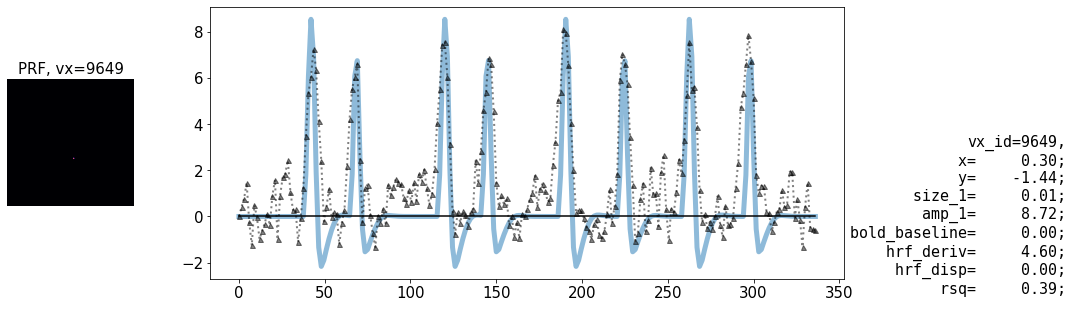

In [39]:
# Ok how did it go! 
# Lets look at an example "microprobe". one of the startgin ones
idx = prf_plotter.pd_params['rsq'].argmax()
walker_id = prf_plotter.pd_params.loc[idx]['walker_id']
step_id = prf_plotter.pd_params.loc[idx]['step_id']
print(f'Walker ID: {walker_id}, Step ID: {step_id}')
_ = prf_plotter.prf_ts_plot(idx)
# Probably not great... but we can see how it goes over time...

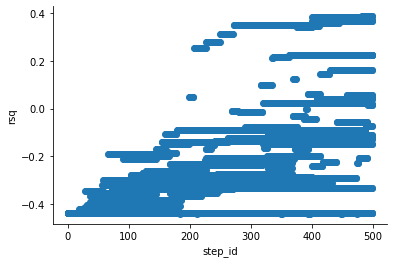

In [40]:
# Lets look at how the rsq changes over time for walker 0
# Should be getting better!!!
prf_plotter.scatter(
    px='step_id', 
    py='rsq', 
    th={},
    # th={'eq-walker_id' : 0,} # Only for walker 0
    )

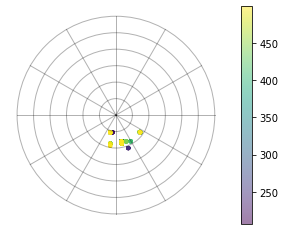

In [42]:
# Now lets do a scatter plot for all the microprobes
prf_plotter.visual_field(
    dot_col='step_id', # Color by rsq
    # th={'min-rsq' : 0, 'min-step_id':100}, # Only show those with rsq > 0
    # th={},
    dot_size=10
    )